# Testing ensemble modeling calibration with synthetic data and custom models
This notebook is designed to test our ensemble modeling capability by generating synthetic data sampled from custom-made SIR-based models. 

### Load dependencies and set up the notebook environment

In [1]:
import os
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyro.nn import pyro_method
from pyro.infer import Predictive
from typing import Dict, Optional

from pyciemss.PetriNetODE.base import (
    ScaledBetaNoisePetriNetODESystem,
    MiraPetriNetODESystem,
    PetriNetODESystem,
    Time,
    State,
    Solution,
    get_name,
)
from pyciemss.utils import state_flux_constraint
from pyciemss.utils import get_tspan
from pyciemss.utils.distributions import ScaledBeta

from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.PetriNetODE.interfaces import sample as sample_petri
from pyciemss.PetriNetODE.interfaces import setup_model as setup_model_petri
from pyciemss.PetriNetODE.interfaces import intervene as intervene_petri
from pyciemss.PetriNetODE.interfaces import calibrate as calibrate_petri

from pyciemss.Ensemble.interfaces import setup_model as setup_model_ensemble
from pyciemss.Ensemble.interfaces import reset_model as reset_model_ensemble
from pyciemss.Ensemble.interfaces import intervene as intervene_ensemble
from pyciemss.Ensemble.interfaces import sample as sample_ensemble
from pyciemss.Ensemble.interfaces import calibrate as calibrate_ensemble
from pyciemss.Ensemble.interfaces import optimize as optimize_ensemble

### Plotting utilities

In [2]:
COLORS=['red','green','blue','black','gold']

def plot_trajectories(sol, tspan, num_params, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate(list(sol.keys())[num_params:]): # skip parameters
        
        if len(sol[list(sol.keys())[3]]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var)
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan[indices], I_low[indices], I_up[indices],
                            alpha=0.2, color=COLORS[i], label=var)
        
        if var[:-4] in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    
    ax.legend()

# Make some models

### Model 1: SIRHD
Model 1 state variables: Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}SI\\ 
\frac{dI}{dt} &= \frac{\beta}{N}SI - \gamma I\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I - \frac{1 - dh}{los}H\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\gamma$ recovery rate, $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [14]:
#import mira
class SIRHD(PetriNetODESystem):
    # Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: infection rate
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "infectious_population": 1, "recovered_population": 2, 
                "hospitalized_population": 3, "deceased_population": 4}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, I, R, H, D = state
        dSdt = -self.beta * S * I / self.total_population
        dIdt = self.beta * S * I / self.total_population - self.gamma * I
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + ((1 - self.dh)/self.los) * H
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dIdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

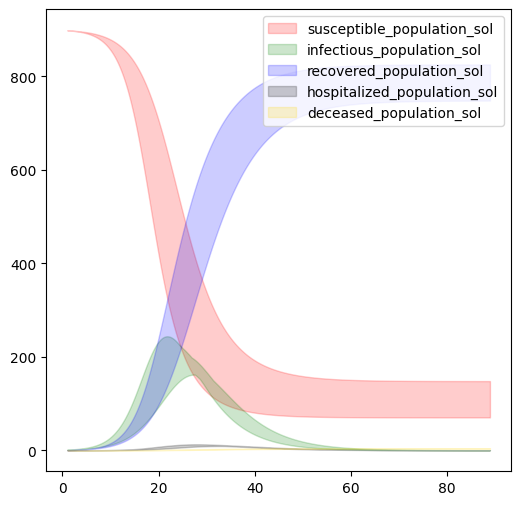

In [15]:
full_tspan = get_tspan(1, 89, 890)
SIRHD_raw  = SIRHD(N=1000.0, beta=0.5, gamma=0.2, hosp=0.05, los=7, dh=0.08, dnh=0.001) # N here unecessary, makes its own
SIRHD_model = setup_model_petri(SIRHD_raw, start_time=0, start_state=dict(susceptible_population=899.0,
                                                                  infectious_population=1.0,
                                                                  recovered_population=0.0, 
                                                                  hospitalized_population=0.0, 
                                                                  deceased_population=0.0))

solution   = sample_petri(SIRHD_model, full_tspan, 10)

num_params = 6
plot_trajectories(solution, full_tspan, num_params=num_params)
plt.show()

In [11]:
solution

{'beta': tensor([0.5230, 0.5383, 0.5057, 0.5405, 0.4643, 0.5378, 0.5314, 0.4621, 0.4623,
         0.5140]),
 'gamma': tensor([0.1960, 0.1885, 0.2108, 0.1809, 0.1809, 0.1985, 0.1938, 0.1941, 0.1833,
         0.1968]),
 'hosp': tensor([0.1812, 0.2033, 0.1844, 0.1887, 0.1890, 0.1941, 0.1987, 0.1948, 0.1926,
         0.1937]),
 'los': tensor([0.2105, 0.1849, 0.2080, 0.1952, 0.1814, 0.1821, 0.1885, 0.2051, 0.1825,
         0.1888]),
 'dh': tensor([0.1978, 0.1825, 0.2004, 0.1823, 0.2087, 0.1885, 0.2054, 0.2003, 0.1986,
         0.2114]),
 'dnh': tensor([0.2080, 0.1928, 0.1812, 0.1996, 0.2199, 0.2051, 0.1884, 0.2138, 0.2124,
         0.1859]),
 'susceptible_population_sol': tensor([[898.4597, 898.3974, 898.3336,  ..., 108.8333, 108.8329, 108.8324],
         [898.4388, 898.3721, 898.3048,  ...,  88.6641,  88.6638,  88.6635],
         [898.4854, 898.4273, 898.3678,  ..., 147.9869, 147.9861, 147.9853],
         ...,
         [898.5353, 898.4835, 898.4304,  ..., 151.3704, 151.3682, 151.3660],
   